In [6]:
import os
import cv2
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt


In [7]:
# print the version of python
print("Python version")
print(os.sys.version)

Python version
3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]


In [8]:
# conda update conda
# conda install -c conda-forge trackpy
# conda install -c conda-forge pims
#conda install pytorch::pytorch torchvision torchaudio -c pytorch

In [9]:
movie_file = '/Users/jonaheaton/Documents/hulahoop_data/videos/DSC_7450.MOV'

In [88]:
import matplotlib.pyplot as plt

def display_channels(image):
    # Split the image into its color channels
    channels = cv2.split(image)

    # Create a figure and subplots
    fig, axs = plt.subplots(2, 3, figsize=(20, 20))

    # Display each channel and its histogram
    for i, ax in enumerate(axs[0]):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i}')

    for i, ax in enumerate(axs[1]):
        ax.hist(channels[i].ravel(), bins=256, color='gray')
        ax.set_yscale('log')
        ax.set_title(f'Channel {i} Histogram')

    plt.tight_layout()
    plt.show()



def basic_process_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    return frame
    # split the frame into a bottom and top half

def split_frame(frame):
    height, width, _ = frame.shape
    top_half = frame[0:800, :]
    bottom_half = frame[800:, :]

    return top_half, bottom_half
   
   

def threshold_frame(frame):
    # Define the lower and upper boundaries for the color orange in the RGB color space
    lower_orange = np.array([200, 80, 50]) # RGB
    upper_orange = np.array([255, 200, 150]) # RGB

    # Find the orange pixels
    # # lower_orange = np.array([10, 100, 100]) # HSV
    # upper_orange = np.array([20, 255, 255]) # HSV


    # Create a mask for the color orange
    mask = cv2.inRange(frame, lower_orange, upper_orange)

    # Optional: Apply dilation to the mask to remove noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)

    # Bitwise-AND the mask and the original image
    segmented_image = cv2.bitwise_and(frame, frame, mask=mask)

    # Find the orange pixels
    # orange_pixels = cv2.inRange(frame, lower_orange, upper_orange)

    return segmented_image



# def process_frame(frame):
#     # Convert the image from BGR to RGB
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Define the lower and upper boundaries for the color orange in the RGB color space
#     lower_orange = np.array([200, 100, 0]) # RGB
#     upper_orange = np.array([255, 165, 0]) # RGB

#     # Find the orange pixels
#     orange_pixels = ((frame_rgb >= lower_orange) & (frame_rgb <= upper_orange)).all(axis=-1)

#     return orange_pixels

In [251]:
def basic_process_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    return frame

def split_frame(frame):
    height, width, _ = frame.shape
    top_half = frame[0:800, :]
    bottom_half = frame[800:, :]

    return top_half, bottom_half

def get_orange_hoop_mask(img):
    # Define the lower and upper boundaries for the color orange in the RGB color space
    # lower_orange = np.array([200, 80, 50]) # RGB
    lower_orange = np.array([180, 80, 50]) # RGB
    upper_orange = np.array([255, 200, 150]) # RGB

    # Create a mask for the color orange
    mask = cv2.inRange(img, lower_orange, upper_orange)

    # Optional: Apply dilation to the mask to remove noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    return mask
    # Bitwise-AND the mask and the original image
    segmented_image = cv2.bitwise_and(img, img, mask=mask)
    return segmented_image


import cv2
import numpy as np

def get_black_hoop_mask(img, orange_mask,box_sz=300):
    '''
    Given top or bottom half of the image
    find the center of mass of the orange mask
    create a rectangle around the center of mass
    within the rectangle find the black hoop masks
    '''
    center = get_center_of_mass(orange_mask)
    box = get_box_from_center(center, box_sz,box_sz)
    x, y, w, h = box
    roi = img[y:y+h, x:x+w]
    
    black_mask_roi = cv2.inRange(roi, np.array([0,0,0]), np.array([50,50,110]))

    # Create a black mask for the full image
    black_mask_full = np.zeros(img.shape[:2], dtype=np.uint8)
    # black_mask_full = np.zeros_like(img)
    
    # Apply the mask from the ROI to the corresponding location in the full image mask
    black_mask_full[y:y+h, x:x+w] = black_mask_roi

    # Optional: Apply dilation to the mask to remove noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(black_mask_full, kernel, iterations = 1)

    return mask

def get_hoop_mask(img):
    '''
    Find the orange mask
    find the black mask
    combine the masks
    '''
    orange_mask = get_orange_hoop_mask(img)
    black_mask = get_black_hoop_mask(img, orange_mask)
    black_mask = remove_large_connected_components(black_mask, 400)
    black_mask = remove_small_connected_components(black_mask, 20)
    hoop_mask = cv2.bitwise_or(orange_mask, black_mask)
    return hoop_mask

def get_center_of_mass(mask):
    '''
    Find the center of mass of the mask
    '''
    moments = cv2.moments(mask)
    cX = int(moments["m10"] / moments["m00"])
    cY = int(moments["m01"] / moments["m00"])
    return (cX, cY)

def get_box_from_center(center, width, height):
    '''
    Create a box of given width and height around the center
    '''
    x = max(0, center[0] - width // 2)
    y = max(0, center[1] - height // 2)
    return (x, y, width, height)

def get_connected_components(mask):
    '''
    Find the connected components of the mask
    '''
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    return num_labels, labels, stats, centroids

def get_area_of_mask(mask):
    '''
    Calculate the area of the mask
    '''
    return cv2.countNonZero(mask)


def remove_large_connected_components(mask, max_area):
    '''
    Remove connected components that are larger than the max area
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_area:
            mask[labels == i] = 0
    return mask

def remove_small_connected_components(mask, min_area):
    '''
    Remove connected components that are smaller than the min area
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area:
            mask[labels == i] = 0
    return mask


def get_object_centroids(mask):
    '''
    Find the centroids of the connected components in the mask
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    return centroids[1:]


def remove_stationay_objects(mask, bad_centroids, dist_th=50):
    '''
    Remove connected components that are smaller than the min area and have centroids close to the bad centroids
    '''

    num_labels, labels, stats, centroids = get_connected_components(mask)
    for i in range(1, num_labels):
        # if stats[i, cv2.CC_STAT_AREA] < threshold:
        for bad_centroid in bad_centroids:
            if np.linalg.norm(bad_centroid - centroids[i]) < 50:
                mask[labels == i] = 0
                break

    return mask

In [188]:
import cv2
import numpy as np

def complete_circle_old(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur the image to reduce noise
    gray = cv2.medianBlur(gray, 5)

    # Use the HoughCircles function to detect circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

    # If at least one circle is detected
    if circles is not None:
        circles = np.uint16(np.around(circles))

        # Draw each circle
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    return gray


def complete_circle(mask):
    # Ensure the mask is a grayscale image
    assert len(mask.shape) == 2

    # Blur the image to reduce noise
    gray = cv2.medianBlur(mask, 5)

    # Use the HoughCircles function to detect circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

    # Create a 3-channel image from the mask
    image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # If at least one circle is detected
    if circles is not None:
        circles = np.uint16(np.around(circles))

        # Draw each circle
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    return image

In [243]:
import cv2
import numpy as np

def overlay_mask(image, mask, color=(0, 255, 0), alpha=0.5):
    # Ensure the mask is a grayscale image
    assert len(mask.shape) == 2

    # Create a 3-channel version of the mask
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Set the color of the mask
    mask_color[mask != 0] = color

    # Blend the original image with the color mask
    overlay = cv2.addWeighted(image, 1 - alpha, mask_color, alpha, 0)

    return overlay

In [233]:


# Load the video
cap = cv2.VideoCapture('/Users/jonaheaton/Documents/hulahoop_data/videos/DSC_7450.MOV')

try:
    while True:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            # We reached the end of the video
            break

        # Process the frame
        frame = basic_process_frame(frame)
        # top_half, bottom_half = split_frame(frame)
        # orange_pixels = threshold_frame(top_half)
        break

        # You can add code here to do something with the processed frame

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Release the video capture object
    cap.release()

# display_channels(frame)

# plt.imshow(orange_pixels)
# plt.axis('off')
# plt.show()

In [234]:
top_half, bottom_half = split_frame(frame)

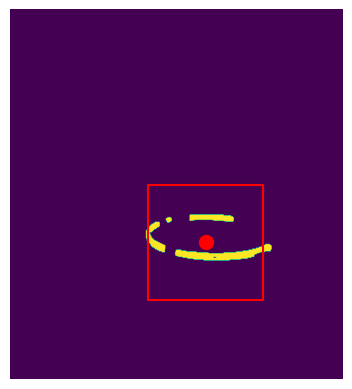

In [235]:
orange_mask = get_orange_hoop_mask(top_half)
center = get_center_of_mass(orange_mask)
box = get_box_from_center(center, 250, 250)

plt.imshow(orange_mask)
plt.axis('off')
# plot the center and box
plt.scatter(center[0], center[1], c='r', s=100)
plt.plot([box[0], box[0]+box[2], box[0]+box[2], box[0], box[0]], 
         [box[1], box[1], box[1]+box[3], box[1]+box[3], box[1]], c='r')

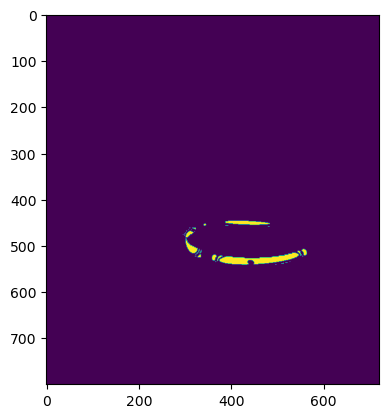

In [239]:
import cv2
import numpy as np

# Assuming 'contours' is a list of contour points
contours, _ = cv2.findContours(orange_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Find the ellipse that fits the contour
for contour in contours:
    if len(contour) >= 5:  # A minimum of 5 points is required
        ellipse = cv2.fitEllipse(contour)
        cv2.ellipse(orange_mask, ellipse, (0,255,0), 2)

plt.imshow(orange_mask)

In [236]:
circles = cv2.HoughCircles(orange_mask, cv2.HOUGH_GRADIENT, dp=10, minDist=200, param1=300, param2=0.95, minRadius=80, maxRadius=100)

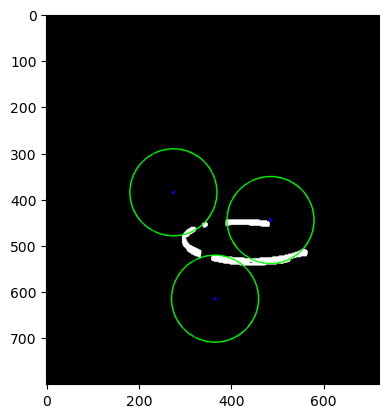

In [237]:
# Create a 3-channel image from the mask
image = cv2.cvtColor(orange_mask, cv2.COLOR_GRAY2BGR)

# If at least one circle is detected
if circles is not None:
    circles = np.uint16(np.around(circles))

    # Draw each circle
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.imshow(image)   

## Get Circle of bottom half

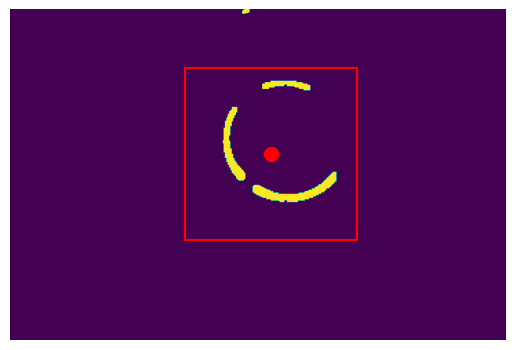

In [159]:
orange_mask = get_orange_hoop_mask(bottom_half)
center = get_center_of_mass(orange_mask)
box = get_box_from_center(center, 250, 250)

plt.imshow(orange_mask)
plt.axis('off')
# plot the center and box
plt.scatter(center[0], center[1], c='r', s=100)
plt.plot([box[0], box[0]+box[2], box[0]+box[2], box[0], box[0]], 
         [box[1], box[1], box[1]+box[3], box[1]+box[3], box[1]], c='r')

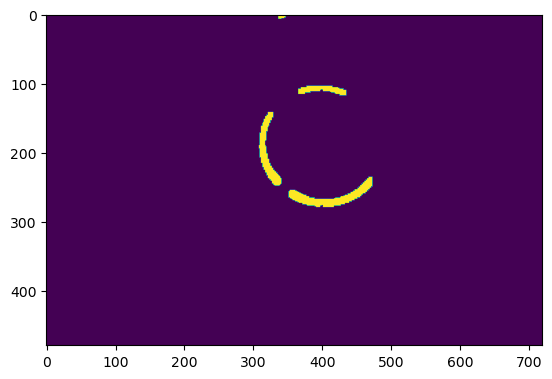

In [194]:
# the figure should be square
plt.imshow(orange_mask)
plt.gca().set_aspect('equal', adjustable='box')


In [228]:
# gray = cv2.medianBlur(orange_mask, 5)
circles = cv2.HoughCircles(orange_mask, cv2.HOUGH_GRADIENT, dp=10, minDist=200, param1=300, param2=0.95, minRadius=80, maxRadius=100)

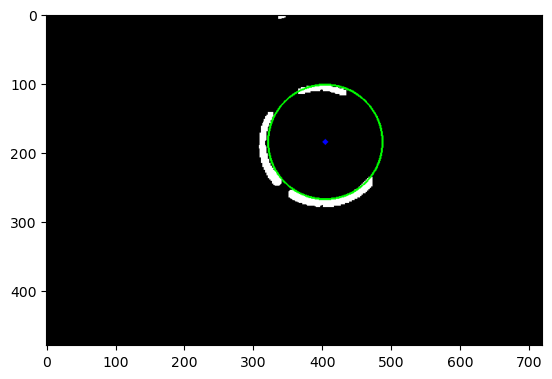

In [229]:
# Create a 3-channel image from the mask
image = cv2.cvtColor(orange_mask, cv2.COLOR_GRAY2BGR)

# If at least one circle is detected
if circles is not None:
    circles = np.uint16(np.around(circles))

    # Draw each circle
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.imshow(image)        

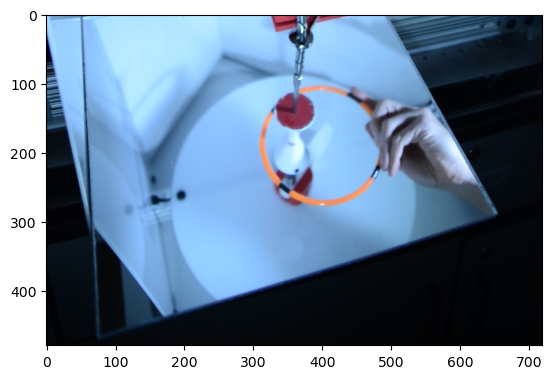

In [187]:
plt.imshow(bottom_half)

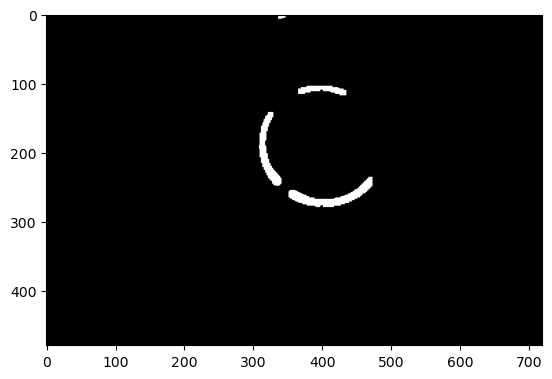

In [189]:
new_image = complete_circle(orange_mask)
plt.imshow(new_image)


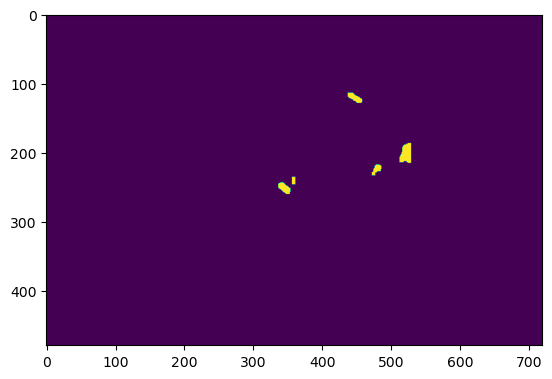

In [167]:
black_mask = get_black_hoop_mask(bottom_half, orange_mask)
black_mask = remove_large_connected_components(black_mask, 400)
black_mask = remove_small_connected_components(black_mask, 30)
plt.imshow(black_mask)

array([[341.90769231,   2.81538462],
       [400.63741722, 109.40231788],
       [447.8839779 , 121.00552486],
       [372.66699572, 237.49884831],
       [522.33419689, 202.05440415],
       [479.54961832, 224.79389313],
       [359.        , 241.        ]])

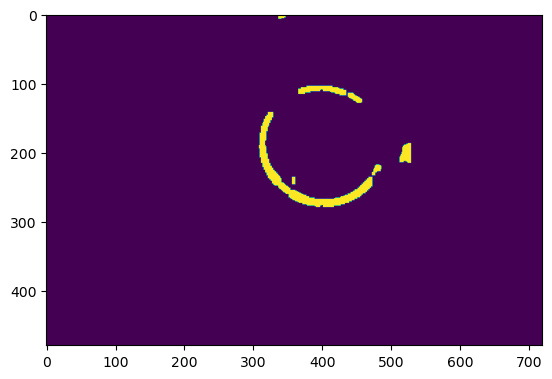

In [176]:
mask = get_hoop_mask(bottom_half)
# mask = remove_stationay_objects(mask, top_half_bad_centroids, dist_th=25)
plt.imshow(mask)
get_object_centroids(mask)

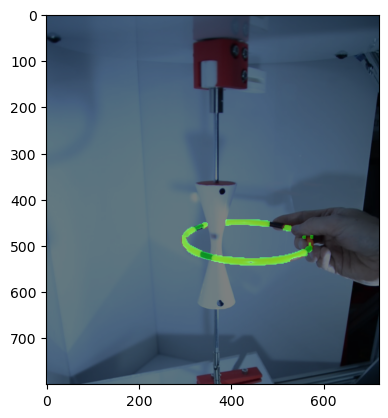

In [252]:
top_half_bad_centroids = [[370.2    , 360.78461538],
                        [379.86419753, 626.51851852]]

mask = get_hoop_mask(top_half)
mask = remove_stationay_objects(mask, top_half_bad_centroids, dist_th=25)
# plt.imshow(mask)

overlay = overlay_mask(top_half,mask)
plt.imshow(overlay)

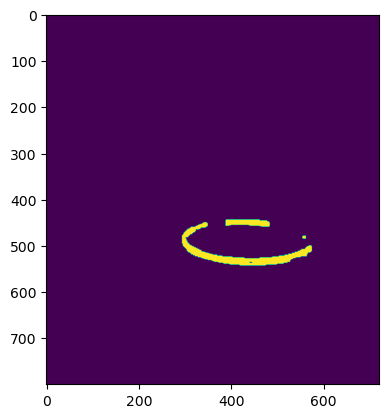

In [245]:
top_half_bad_centroids = [[370.2    , 360.78461538],
                        [379.86419753, 626.51851852]]

mask = get_hoop_mask(top_half)
mask = remove_stationay_objects(mask, top_half_bad_centroids, dist_th=25)
plt.imshow(mask)

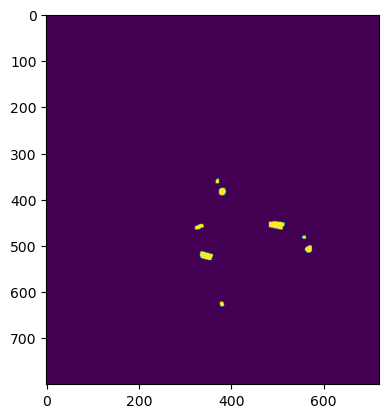

In [242]:
orange_mask = get_orange_hoop_mask(top_half)
black_hoop = get_black_hoop_mask(top_half, orange_mask)

plt.imshow(black_hoop)

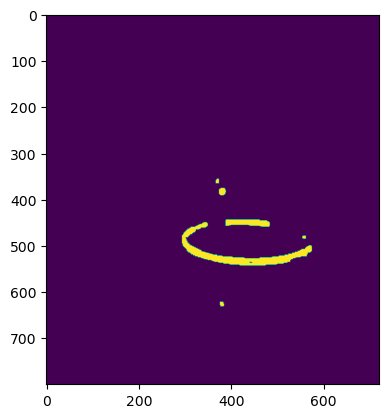

In [244]:
mask =get_hoop_mask(top_half)
plt.imshow(mask)

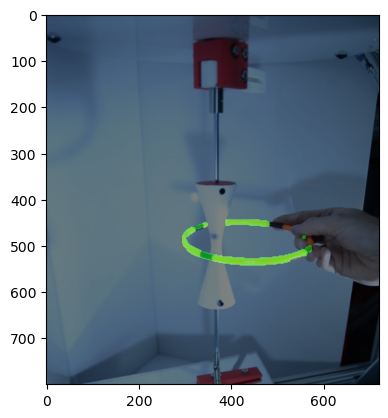

In [247]:
overlay = overlay_mask(top_half,mask)
plt.imshow(overlay)

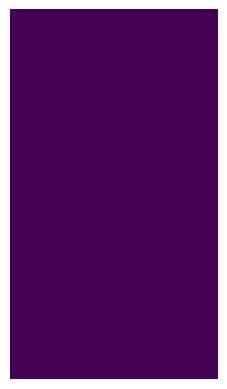

In [29]:
plt.imshow(processed_frame)
plt.axis('off')
plt.show()

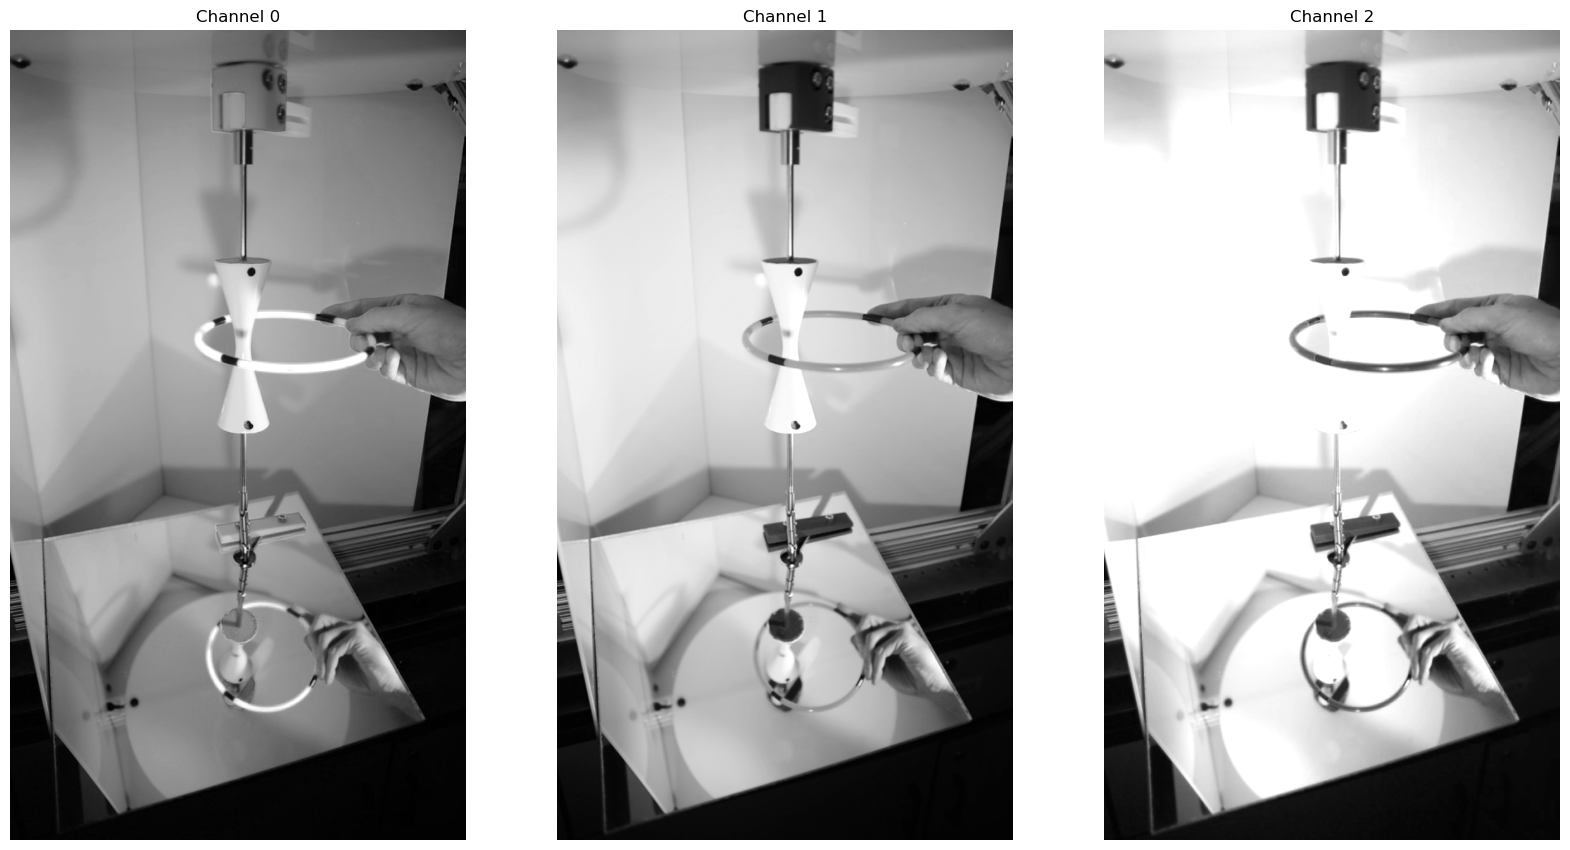

In [34]:
# Use the function on your processed frame
display_channels(processed_frame)

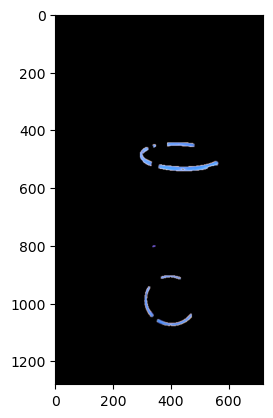

In [90]:
lower_orange = np.array([200, 80, 50]) # RGB
upper_orange = np.array([255, 200, 150]) # RGB

# Find the orange pixels
# # lower_orange = np.array([10, 100, 100]) # HSV
# upper_orange = np.array([20, 255, 255]) # HSV


# Create a mask for the color orange
mask = cv2.inRange(frame, lower_orange, upper_orange)

# Optional: Apply dilation to the mask to remove noise
kernel = np.ones((5,5), np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 1)

# Bitwise-AND the mask and the original image
segmented_image = cv2.bitwise_and(frame, frame, mask=mask)

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.show()

In [128]:
lower_orange = np.array([200, 80, 50]) # RGB
upper_orange = np.array([255, 200, 150]) # RGB

# Find the orange pixels
# # lower_orange = np.array([10, 100, 100]) # HSV
# upper_orange = np.array([20, 255, 255]) # HSV


# Create a mask for the color orange
mask = cv2.inRange(frame, lower_orange, upper_orange)

# Create connected components
num_labels, labels = cv2.connectedComponents(mask)

# Remove small connected components
# Convert labels to 8-bit
labels_8u = np.uint8(labels)

# Remove small connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels_8u, connectivity=8)

# Continue with the rest of your code...
# Filter out small components based on area (e.g., keep only components with area > 30)
min_area = 30
large_components_mask = np.isin(labels, np.where(stats[:, cv2.CC_STAT_AREA] > min_area))

# Apply the mask to keep only the large components
mask = np.where(large_components_mask, labels, 0)



# Convert mask to 8-bit
mask_8u = np.uint8(mask)

# Apply dilation to the mask to remove noise
kernel = np.ones((31,31), np.uint8)
mask = cv2.dilate(mask_8u, kernel, iterations = 2)


num_labels, labels = cv2.connectedComponents(mask)

# Remove small connected components
# Convert labels to 8-bit
labels_8u = np.uint8(labels)

# Remove small connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels_8u, connectivity=8)

# Continue with the rest of your code...
# Filter out small components based on area (e.g., keep only components with area > 30)
min_area = 30
large_components_mask = np.isin(labels, np.where(stats[:, cv2.CC_STAT_AREA] > min_area))

# Apply the mask to keep only the large components
mask = np.where(large_components_mask, labels, 0)

# Convert mask to 8-bit
mask_8u = np.uint8(mask)

num_labels, labels = cv2.connectedComponents(mask)

# # Remove small connected components
# # Convert labels to 8-bit
# labels_8u = np.uint8(labels)

# # Remove small connected components
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels_8u, connectivity=8)
# # use the stats to get the bounding box of the components
# # Get the bounding boxes of the connected components
# bounding_boxes = stats[:, cv2.CC_STAT_LEFT:cv2.CC_STAT_WIDTH+1]

# # Draw the bounding boxes on the original image
# for box in bounding_boxes:
#     x, y, w, h = box
#     cv2.rectangle(segmented_image, (x, y), (x+w, y+h), (0, 255, 0), 2)


# plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.imshow(mask, cmap='gray')
plt.show()

error: OpenCV(4.9.0) /Users/runner/miniforge3/conda-bld/libopencv_1716151551714/work/modules/imgproc/src/connectedcomponents.cpp:5632: error: (-215:Assertion failed) iDepth == CV_8U || iDepth == CV_8S in function 'connectedComponents_sub1'


In [125]:
stats

array([[     0,      0,    720,   1280, 848954],
       [   266,    416,    328,    156,  39745],
       [   281,    876,    221,    232,  32901]], dtype=int32)

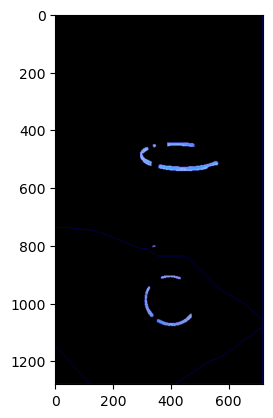

In [92]:
import cv2
import numpy as np

# Convert the image to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold to the grayscale image
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform a series of dilations to remove noise from the threshold image
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(segmented_image, markers)
segmented_image[markers == -1] = [255, 0, 0]

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.show()

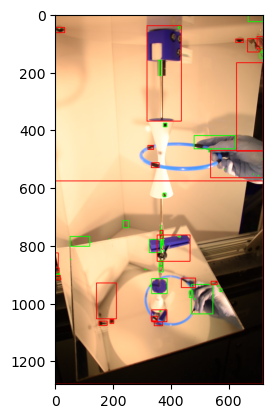

In [105]:
import cv2
import numpy as np

# Find contours in the threshold image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the bounding box on the original image
    # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Get the region of the image inside the bounding box
    roi = frame[y:y+h, x:x+w]


    lower_bound = np.array([20, 30, 70]) # RGB
    upper_bound = np.array([40, 60, 90]) # RGB

    # Create a mask for the color of interest
    mask = cv2.inRange(roi, lower_bound, upper_bound)
    
    count_pixels = cv2.countNonZero(mask)
    if count_pixels > 3:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

    # Count the number of black pixels in the region
    # chosen_pixels = roi[]

    # print(f'Number of black pixels in the box: {black_pixels}')

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [103]:
roi

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 66, 107, 149],
        ...,
        [ 53,  92, 133],
        [ 53,  92, 133],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 72, 113, 155],
        ...,
        [ 64, 103, 144],
        [ 64, 103, 144],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 74, 115, 159],
        ...,
        [ 64, 105, 147],
        [ 64, 105, 147],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [102]:
roi.reshape(-1, 3)

array([[  0, 255,   0],
       [  0, 255,   0],
       [  0, 255,   0],
       ...,
       [  0, 255,   0],
       [  0, 255,   0],
       [  0, 255,   0]], dtype=uint8)

Number of black pixels in the box: 80
Number of black pixels in the box: 151
Number of black pixels in the box: 100
Number of black pixels in the box: 121296
Number of black pixels in the box: 218
Number of black pixels in the box: 3747
Number of black pixels in the box: 88


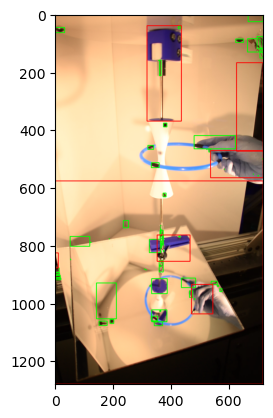

In [96]:
import cv2
import numpy as np

# Find contours in the threshold image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the bounding box on the original image
    # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Get the region of the image inside the bounding box
    roi = gray[y:y+h, x:x+w]

    # Count the number of black pixels in the region
    black_pixels = np.count_nonzero(roi < 20)
    if black_pixels > 10:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        print(f'Number of black pixels in the box: {black_pixels}')

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [97]:
roi

array([[115, 115, 115, ..., 100, 100, 100],
       [115, 115, 115, ..., 100, 100, 100],
       [115, 115, 115, ..., 100, 100, 100],
       ...,
       [121, 121, 121, ..., 111, 111, 111],
       [123, 123, 123, ..., 113, 113, 113],
       [124, 124, 124, ..., 114, 114, 114]], dtype=uint8)

In [98]:
gray

array([[160, 160, 160, ..., 100, 100, 100],
       [160, 160, 160, ..., 100, 100, 100],
       [161, 161, 161, ..., 100, 100, 100],
       ...,
       [  7,   8,   6, ...,   3,   3,   3],
       [  7,   8,   7, ...,   3,   3,   3],
       [  7,   7,   7, ...,   3,   3,   3]], dtype=uint8)